# Investigate Volatility of SPY

This notebook investigates the volatility of SPY

### Import & Format Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta

In [328]:
spy = pd.read_csv('./data/price/SPY.csv', index_col='Date', parse_dates=True)
print('SPY\t', spy.shape)

# Limit data to last xx years
last_years = 255*2
# spy = spy.iloc[-last_years:]
print('SPY\t', spy.shape)

SPY	 (6689, 6)
SPY	 (6689, 6)


In [329]:
df = pd.DataFrame(spy['Adj Close'].rename('price'))
df['pct_change'] = df.price.pct_change()
df['log_return'] = np.log(df.price).diff()
df = df.iloc[1:]
y = df['log_return']

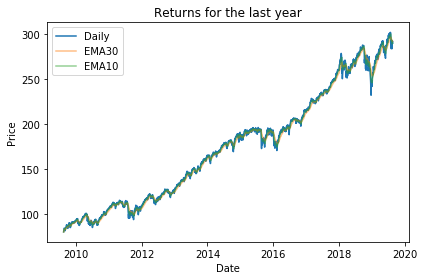

In [322]:
day_limit = 252 * 10

daily = df.price[-day_limit:]
ema10 = daily.ewm(span=10).mean().dropna()
ema30 = daily.ewm(span=30).mean().dropna()

plt.plot(daily, label='Daily')
plt.plot(ema30, alpha=.5, label='EMA30')
plt.plot(ema10, alpha=.5, label='EMA10')

plt.title('Returns for the last year')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

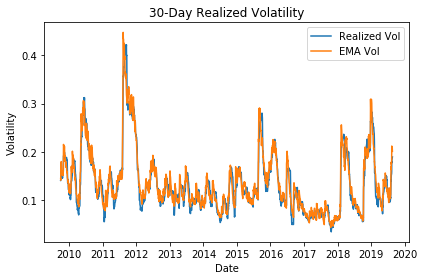

In [330]:
time_frame = 30 # monthly volatility

daily_returns = y[-day_limit:]
daily_mean = daily_returns.mean()

realized_var = daily_returns.rolling(time_frame).var(ddof=0) * np.sqrt(252)
realized_var.dropna(inplace=True)

realized_vol = daily_returns.rolling(time_frame).std(ddof=0) * np.sqrt(252)
realized_vol.dropna(inplace=True)

ema_vol = daily_returns.ewm(span=time_frame).std(ddof=0) * np.sqrt(252)
ema_vol = ema_vol[time_frame - 1:]

plt.plot(realized_vol, label='Realized Vol')
plt.plot(ema_vol, label='EMA Vol')

plt.title('{}-Day Realized Volatility'.format(time_frame))
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()

### Create simple predictions

In [325]:
# historical average
ham = y.expanding().std(ddof=0)[-day_limit:]
ham = ham[time_frame - 1:] * np.sqrt(252)
ham = ham.shift(1).dropna()

# simple moving average
sma = realized_vol.shift(1).dropna()

# exponentially weighted moving average
ewma = ema_vol.shift(1).dropna()
ewma_span = ema_vol_span.shift(1).dropna()

In [327]:
# Evaluate predictions
def error_stats(actuals, predicted):
    assert actuals.shape == predicted.shape, 'Input shapes not the same: {}, {}'.format(actuals.shape, predicted.shape)
    N = actuals.shape[0]
    
    # Find error statistics
    residuals = predicted - actuals
    res_student = residuals / np.std(residuals)
    
    mse = sum(residuals**2) / N
    rmse = np.sqrt(mse)
    nrmse = rmse / (max(actuals) - min(actuals))
    msd = sum(residuals) / N
    mae = sum(abs(residuals)) / N
    mlae = sum(np.log(abs(residuals))) / N
    smape = sum(abs(residuals) / (abs(actuals) + abs(predicted))) / N
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(actuals, predicted)
    r_square = r_value**2
    
    return ([mse, rmse, nrmse, msd, mae, mlae, smape, r_square],
            ['MSE', 'RMSE', 'nRMSE', 'MSD', 'MAE', 'MLAE', 'sMAPE', 'R-Square'])

ham_error_stats,  test_names = error_stats(realized_vol[1:], ham)
sma_error_stats,  test_names = error_stats(realized_vol[1:], sma)
ewma_error_stats, test_names = error_stats(realized_vol[1:], ewma)

error_stats_df = pd.DataFrame()
error_stats_df['HAM']  = ham_error_stats
error_stats_df['SMA']  = sma_error_stats
error_stats_df['EWMA'] = ewma_error_stats
error_stats_df.index = test_names

pd.set_option('display.float_format', lambda x: '%f' % x)
print(error_stats_df)

error_stats_df.loc['R-Square'] = 1 - error_stats_df.loc['R-Square']
error_stats_df.loc['MLAE'] = 1 / error_stats_df.loc['MLAE']
print('\nCounts of Best Values:')
print(abs(error_stats_df).idxmin(axis=1))
print()
print(abs(error_stats_df).idxmin(axis=1).value_counts())

               HAM       SMA      EWMA
MSE       0.007215  0.000046  0.000266
RMSE      0.084944  0.006782  0.016315
nRMSE     0.219309  0.017511  0.042123
MSD       0.058620 -0.000011  0.003323
MAE       0.076820  0.003523  0.012265
MLAE     -2.750406 -6.788261 -4.843256
sMAPE     0.256351  0.014119  0.047761
R-Square  0.083749  0.988406  0.935781

Counts of Best Values:
MSE         SMA
RMSE        SMA
nRMSE       SMA
MSD         SMA
MAE         SMA
MLAE        SMA
sMAPE       SMA
R-Square    SMA
dtype: object

SMA    8
dtype: int64


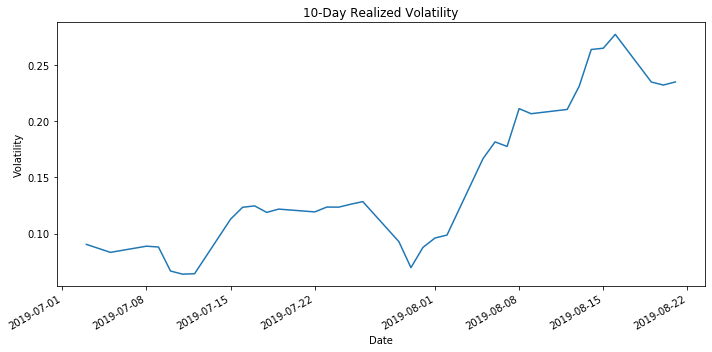

In [392]:
time_frame = 10

num_months = 22 * 2
daily_returns = y[-num_months:]
realized_vol = daily_returns.rolling(time_frame).std(ddof=0) * np.sqrt(252)
realized_vol.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(realized_vol)

ax.set_title('{}-Day Realized Volatility'.format(time_frame))
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
fig.autofmt_xdate()
fig.tight_layout()
plt.show()